# Project 2: Continuous Control

---

We apply continuous control to the multi-agent Reacher environment to train an armed agent to keep the arm in the target location

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [5]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [6]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [8]:
print('[ info ] Brain name',brain_name)
print('[ info ] Brain', brain)

[ info ] Brain name ReacherBrain
[ info ] Brain Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [10]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.16199999637901782


When finished, you can close the environment.

In [11]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Actor (Policy) Model and Critic (Value) Model

In [12]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [13]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""
    def __init__(self, state_size, action_size, seed = 0, 
                 fc_units = [400,300]):
        """
        Initialize parameters and build model.
        Params
        ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of action
        seed (int): Random seed
        fc1_units (int): Number of nodes in first hidden layer
        fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        self.fc3 = nn.Linear(fc_units[1], action_size)
        self.reset_parameters()
    
    def reset_parameters(self):
        """
        Reset parameters
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        """
        Build an Actor (Policy) network that maps states -> actions.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

class Critic(nn.Module):
    """
    Critic (Value) Model.
    """
    def __init__(self, state_size, action_size, seed = 0, 
                 fc_units = [400,300]):
        """
        Initialize parameters and build model.
        Params
        ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fcs1_units (int): Number of nodes in first hidden layer
        fc2_units (int): Number of nodes in second hidden layer
        fc3_units (int): Number of nodes in third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0] + action_size, fc_units[1]) # because we concat later
        self.fc3 = nn.Linear(fc_units[1], 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        """
        Reset parameters
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        """
        Build a Critic (Value) Network that maps (state, action) pairs -> Q-values.
        """
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim = 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [14]:
actor = Actor(state_size, action_size)
print(actor)

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)


In [15]:
critic = Critic(state_size, action_size)
print(critic)

Critic(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### 6. Deep Deterministic Policy Gradients (DDPG) Agent

Parameters to be used by the Agent during training

In [16]:
params = {'BUFFER_SIZE':int(1e6), # Replay buffer size
         'BATCH_SIZE':128, # minibatch size
         'GAMMA':0.99, # discount factor
         'TAU':1e-3, # for soft update of target parameters
         'LR_ACTOR':1e-4, # learning rate of the Actor
         'LR_CRITIC':1e-3, # Learning rate of the Critic
         'WEIGHT_DECAY':0., # L2 weight decay,
         'DEVICE': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')} 
params

{'BUFFER_SIZE': 1000000,
 'BATCH_SIZE': 128,
 'GAMMA': 0.99,
 'TAU': 0.001,
 'LR_ACTOR': 0.0001,
 'LR_CRITIC': 0.001,
 'WEIGHT_DECAY': 0.0,
 'DEVICE': device(type='cpu')}

## 6.1 OUNoise
The Ornstein-Uhlebneck Process is used by the agent to enable exploration.


In [18]:
class OUNoise(object):
    """ Ornstein-Uhlenbeck Process."""
    def __init__(self, size, seed = 0, mu = 0., theta = 0.15, sigma = 0.2):
        """Initialize parameters and noise process.
        Params
        =====
        size (int): size of the space
        seed (int): seed value
        mu: mean
        theta: theta
        sigma: sigma
        """
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()
    
    def reset(self):
        """ Reset the internal state (= noise) to mean (mu)"""
        self.state = copy.copy(self.mu)
    
    def sample(self):
        """
        Update internal state and return it as a noise sample
        """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## 6.2 Replay Buffer
The replay buffer for learning from uncorrelated transitions.

In [19]:
class ReplayBuffer(object):
    """
    Fixed-size replay buffer to store experience tuples.
    """
    def __init__(self, action_size, buffer_size, batch_size, seed = 0):
        """
        Initialize a ReplayBuffer object
        Params
        ======
        action_size (int): Dimension of actions
        buffer_size (int): Maximum size of buffer
        batch_size (int): Size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """
        Randomly sample a batch of experiences from memory.
        """
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(params['DEVICE'])
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(params['DEVICE'])
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(params['DEVICE'])
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(params['DEVICE'])
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(params['DEVICE'])

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """
        Return the current size of internal memory
        """
        return len(self.memory)
        

## 6.3 The Deep Deterministic Policy Gradient Agent
This is where the magic happens. The agent interacts with and learns from the environment. It also uses the Actor-Critic networks, OUNoise and Replay Buffer during training to aid learning.

In [20]:
class Agent(object):
    """
    The Agent interacts with and learns from the environment.
    """
    def __init__(self, state_size, action_size, num_agents, random_seed = 0, params = params):
        """
        Initialize an Agent object.
        Params
        ======
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        num_agents (int): number of agents
        random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.params = params
        
        # Actor (Policy) Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(self.params['DEVICE'])
        self.actor_target = Actor(state_size, action_size, random_seed).to(self.params['DEVICE'])
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.params['LR_ACTOR'])
        
        # Critic (Value) Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(self.params['DEVICE'])
        self.critic_target = Critic(state_size, action_size, random_seed).to(self.params['DEVICE'])
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = self.params['LR_CRITIC'], weight_decay = self.params['WEIGHT_DECAY'])
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, self.params['BUFFER_SIZE'], self.params['BATCH_SIZE'], random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        """
        Save experiences in replay memory and use random sample from buffer to learn.
        """
        
        # Save experience / reward, cater for when multiples
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn if enough samples are available in memory
        if len(self.memory) > self.params['BATCH_SIZE']:
            experiences = self.memory.sample()
            self.learn(experiences, self.params['GAMMA'])
    
    def act(self, states, add_noise = True):
        """
        Returns actions for a given state as per current policy.
        """
        states = torch.from_numpy(states).float().to(self.params['DEVICE'])
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for i, state in enumerate(states):
                actions[i, :] = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def learn(self, experiences, gamma = params['GAMMA']):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Update Critic(Value)
        # Get predicted next-state actions and Q-Values from target Network
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q Targe for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimise the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1) # Stabilize learning per bernchmark guidelines
        self.critic_optimizer.step()
        
        # Update Actor (Policy)
        # Compute Actor Loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update target networks
        self.soft_update(self.critic_local, self.critic_target, tau = self.params['TAU'])
        self.soft_update(self.actor_local, self.actor_target, tau = self.params['TAU'])
    
    def soft_update(self, local_model, target_model, tau = params['TAU']):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau) * target_param.data)
            

In [21]:
agent = Agent(state_size, action_size, num_agents, random_seed = 0)
agent

### 7. Train the Agent with DDPG
Now we train the agent using DDPG function.

In [17]:
def ddpg(n_episodes = 2000, max_t = 1000):
    scores_deque = deque(maxlen = 100) #
    scores_all = [] #
    max_score = -np.inf #
    
    # Episodes
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = True)[brain_name] #
        states = env_info.vector_observations # Since we have multiple agents, each agent has a state
        agent.reset() #
        scores = np.zeros(num_agents) #
        max_score = -np.inf
        # Timesteps
        for t in range(max_t):
            actions = agent.act(states) #
            env_info = env.step(actions)[brain_name] #
            next_states = env_info.vector_observations # All next states for all agents
            rewards = env_info.rewards # all rewards for all agents
            dones = env_info.local_done # episodes dones for all agents
            agent.step(states, actions, rewards, next_states, dones) #
            states = next_states # update to next states
            scores += rewards # tally up the scores here
            if np.any(dones): #
                break #
        episode_avg_score = np.mean(scores)
        scores_deque.append(episode_avg_score)
        scores_all.append(episode_avg_score)
        average_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, average_score, episode_avg_score), end="")
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if average_score >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            # Final save
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return scores_all

scores = ddpg()


Episode 20	Average Score: 1.55	Score: 2.81
Episode 40	Average Score: 3.19	Score: 6.38
Episode 60	Average Score: 4.99	Score: 10.68
Episode 80	Average Score: 6.31	Score: 11.94
Episode 100	Average Score: 7.74	Score: 15.00
Episode 120	Average Score: 10.90	Score: 18.61
Episode 140	Average Score: 14.04	Score: 21.24
Episode 160	Average Score: 17.08	Score: 24.75
Episode 180	Average Score: 20.19	Score: 27.09
Episode 200	Average Score: 22.93	Score: 27.67
Episode 220	Average Score: 25.23	Score: 28.92
Episode 240	Average Score: 27.05	Score: 31.99
Episode 260	Average Score: 28.60	Score: 33.07
Episode 280	Average Score: 30.04	Score: 33.37

Environment solved in 280 episodes!	Average Score: 30.04


NameError: name 'plt' is not defined

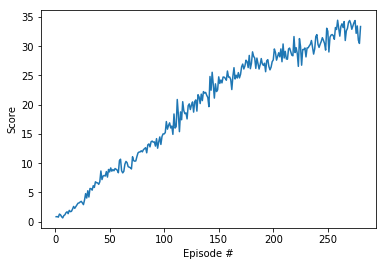

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()